In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Import data and correct spelling of original column headers for consistency

In [3]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})
print(df.head())

   step      type    amount     nameOrig  oldBalanceOrig  newBalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815        170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295         21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145           181.0            0.00   
3     1  CASH_OUT    181.00   C840083671           181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720         41554.0        29885.86   

      nameDest  oldBalanceDest  newBalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


Test if there any missing values in DataFrame. It turns out there are no
obvious missing values but, as we will see below, this does not rule out proxies by a numerical
value like 0.

In [4]:
df.isnull().values.any()

False

In [5]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldBalanceOrig',
       'newBalanceOrig', 'nameDest', 'oldBalanceDest', 'newBalanceDest',
       'isFraud', 'isFlaggedFraud'],
      dtype='object')

# EDA

A step-wise explanation of how transaction fraud and flagged fraud are represented and interpreted 

---

### Dataset Columns Overview

* **step**: Time step of the transaction (could be hours, days, etc.)
* **type**: Type of transaction (e.g., 'TRANSFER', 'CASH\_OUT', 'CASH\_IN', 'PAYMENT', etc.)
* **amount**: Amount of money involved in the transaction
* **nameOrig**: Identifier for the originator (sender) account
* **oldBalanceOrig**: Balance of the originator account before the transaction
* **newBalanceOrig**: Balance of the originator account after the transaction
* **nameDest**: Identifier for the destination (receiver) account
* **oldBalanceDest**: Balance of the destination account before the transaction
* **newBalanceDest**: Balance of the destination account after the transaction
* **isFraud**: Binary flag indicating if the transaction is confirmed fraudulent (1) or not (0)
* **isFlaggedFraud**: Binary flag that should indicate if the transaction was flagged as potentially fraudulent before confirmation (but unclear in practice)

---

### Stepwise Explanation of Fraud and Flagged Fraud Detection

#### Step 1: Transaction Types and Fraud Occurrence

* Fraudulent transactions are found **only in 'TRANSFER' and 'CASH\_OUT' types**.
* Fraud typically involves **transferring funds to a fraudulent account** ('TRANSFER'), followed by that account **withdrawing money via 'CASH\_OUT'**.
* Other types like 'CASH\_IN' or 'PAYMENT' are not involved in fraud based on this data.

---

#### Step 2: Understanding the *isFraud* Column

* **`isFraud` is the confirmed indicator of fraud**, set to 1 for fraudulent transactions.
* Fraud transactions show specific patterns but do **not always match expected schemes** exactly.
* For example, the expected fraud modus operandi (TRANSFER to a fraudulent account followed by CASH\_OUT from the same account) is **not clearly present** in the data.

---

#### Step 3: The *isFlaggedFraud* Column – Intended vs Actual Behavior

* Intended: `isFlaggedFraud` should flag transactions for high-value transfers (e.g., TRANSFER > 200,000).
* Actual:

  * It is set only 16 times in over 6 million transactions, showing **extreme rarity and inconsistency**.
  * It does **not correlate clearly with transaction amount, balance changes, or customer transaction frequency**.
  * In flagged transactions, balances often remain unchanged, implying **halted or blocked transactions**.
  * Since `isFlaggedFraud` is set so infrequently and inconsistently, it is **not a reliable feature** for detecting fraud and is often discarded.

---

#### Step 4: Role of Account Balances in Fraud Detection

* In flagged transactions, **old and new balances for both originator and destination accounts sometimes remain the same**, indicating the transaction may have been prevented.
* However, similar balance patterns occur in unflagged transactions, meaning **balance values alone do not determine fraud or flags**.
* Post-transaction balances (`newBalanceOrig`) are not useful for flagging since flags are set before transaction completion.

---

#### Step 5: Customer Account Behavior and Fraud Flags

* Originator accounts with `isFlaggedFraud` set generally transact only once — **no multiple transactions trigger the flag**.
* Destination accounts rarely transact multiple times when flagged.
* This means that **transaction frequency per customer is not a reliable indicator for flagging fraud**.

---

#### Step 6: Merchant Accounts and Fraud

* Merchants (account names prefixed with 'M') do **not behave as expected**:

  * No merchants are originators in any transactions.
  * Merchants appear only as destinations in PAYMENT transactions.
  * CASH\_IN and CASH\_OUT do not show merchants interacting as described in the dataset documentation.
* This inconsistency means that **merchant-related fields (`nameOrig`, `nameDest`) are unreliable for fraud detection**.

---

#### Step 7: Summary and Practical Use in Modeling

* **`isFraud` is the primary and reliable target variable** indicating confirmed fraud.
* **`isFlaggedFraud` is unreliable and can generally be discarded** without losing information.
* **Features like transaction type, amount, and balances can help detect fraud**, but complex patterns and inconsistencies exist.
* **`nameOrig` and `nameDest` (account IDs) are often meaningless for fraud detection** and are commonly dropped in modeling.
* The **time step (`step`) does not correlate with flagged fraud**, and fraud occurs across all times.

---

### Summary Table of Key Points

| Feature          | Role/Observation                             | Usefulness for Fraud Detection                         |
| ---------------- | -------------------------------------------- | ------------------------------------------------------ |
| `step`           | Transaction time                             | No correlation with fraud or flagging                  |
| `type`           | Transaction type (TRANSFER, CASH\_OUT, etc.) | Fraud only in TRANSFER and CASH\_OUT                   |
| `amount`         | Transaction amount                           | Higher amounts expected but not decisive alone         |
| `nameOrig`       | Originator account ID                        | Unreliable, dropped due to inconsistent use            |
| `oldBalanceOrig` | Originator balance before transaction        | Overlaps for flagged/unflagged, not decisive           |
| `newBalanceOrig` | Originator balance after transaction         | Not relevant for flagging (post-transaction)           |
| `nameDest`       | Destination account ID                       | Unreliable, dropped due to inconsistent use            |
| `oldBalanceDest` | Destination balance before transaction       | Sometimes zero in flagged transactions, but not unique |
| `newBalanceDest` | Destination balance after transaction        | Similar to oldBalanceDest, not unique                  |
| `isFraud`        | Confirmed fraud flag                         | Primary reliable target variable                       |
| `isFlaggedFraud` | Flagged fraud (before confirmation)          | Rare, inconsistent, often discarded                    |

---




In [27]:
# Fraudulent transaction types and counts
fraud_types = list(df.loc[df.isFraud == 1, 'type'].drop_duplicates().values)
dfFraudTransfer = df[(df.isFraud == 1) & (df.type == 'TRANSFER')]
dfFraudCashout = df[(df.isFraud == 1) & (df.type == 'CASH_OUT')]

print('\nThe types of fraudulent transactions are:', fraud_types)
print('The number of fraudulent TRANSFERs =', len(dfFraudTransfer))
print('The number of fraudulent CASH_OUTs =', len(dfFraudCashout))



The types of fraudulent transactions are: ['TRANSFER', 'CASH_OUT']
The number of fraudulent TRANSFERs = 4097
The number of fraudulent CASH_OUTs = 4116


In [28]:
# Transactions where isFlaggedFraud is set, amount stats, and balances

flagged_types = list(df.loc[df.isFlaggedFraud == 1, 'type'].drop_duplicates())
dfTransfer = df[df.type == 'TRANSFER']
dfFlagged = df[df.isFlaggedFraud == 1]
dfNotFlagged = df[df.isFlaggedFraud == 0]

min_amount_flagged = dfFlagged.amount.min()
max_amount_not_flagged_transfer = dfTransfer.loc[dfTransfer.isFlaggedFraud == 0, 'amount'].max()

flagged_zero_balances = dfTransfer.loc[
    (dfTransfer.isFlaggedFraud == 0) & 
    (dfTransfer.oldBalanceDest == 0) & 
    (dfTransfer.newBalanceDest == 0)
]
num_flagged_zero_balances = len(flagged_zero_balances)

oldBalanceOrig_min_flagged = round(dfFlagged.oldBalanceOrig.min())
oldBalanceOrig_max_flagged = round(dfFlagged.oldBalanceOrig.max())

oldBalanceOrig_min_unflagged = dfTransfer.loc[
    (dfTransfer.isFlaggedFraud == 0) & (dfTransfer.oldBalanceOrig == dfTransfer.newBalanceOrig), 
    'oldBalanceOrig'
].min()

oldBalanceOrig_max_unflagged = round(dfTransfer.loc[
    (dfTransfer.isFlaggedFraud == 0) & (dfTransfer.oldBalanceOrig == dfTransfer.newBalanceOrig), 
    'oldBalanceOrig'
].max())

print('\nTypes with isFlaggedFraud set:', flagged_types)
print('Min amount when isFlaggedFraud is set:', min_amount_flagged)
print('Max amount in TRANSFER where isFlaggedFraud is NOT set:', max_amount_not_flagged_transfer)
print('Number of TRANSFERs where isFlaggedFraud=0 but oldBalanceDest=0 and newBalanceDest=0:', num_flagged_zero_balances)
print(f'Min, Max oldBalanceOrig for isFlaggedFraud=1 TRANSFERs: {oldBalanceOrig_min_flagged}, {oldBalanceOrig_max_flagged}')
print(f'Min, Max oldBalanceOrig for isFlaggedFraud=0 TRANSFERs where oldBalanceOrig == newBalanceOrig: {oldBalanceOrig_min_unflagged}, {oldBalanceOrig_max_unflagged}')



Types with isFlaggedFraud set: ['TRANSFER']
Min amount when isFlaggedFraud is set: 353874.22
Max amount in TRANSFER where isFlaggedFraud is NOT set: 92445516.64
Number of TRANSFERs where isFlaggedFraud=0 but oldBalanceDest=0 and newBalanceDest=0: 4158
Min, Max oldBalanceOrig for isFlaggedFraud=1 TRANSFERs: 353874, 19585040
Min, Max oldBalanceOrig for isFlaggedFraud=0 TRANSFERs where oldBalanceOrig == newBalanceOrig: 0.0, 575668


In [29]:
# Check transaction frequency for flagged originators and destinations
flagged_orig_in_nonflagged = dfFlagged.nameOrig.isin(pd.concat([dfNotFlagged.nameOrig, dfNotFlagged.nameDest])).any()
flagged_dest_in_nonflagged_orig = dfFlagged.nameDest.isin(dfNotFlagged.nameOrig).any()
flagged_dest_repeated = sum(dfFlagged.nameDest.isin(dfNotFlagged.nameDest))

print('Have originators of flagged transactions transacted more than once?', flagged_orig_in_nonflagged)
print('Have destinations of flagged transactions initiated other transactions?', flagged_dest_in_nonflagged_orig)
print('Number of destination accounts in flagged transactions that have been destination accounts more than once:', flagged_dest_repeated)


Have originators of flagged transactions transacted more than once? False
Have destinations of flagged transactions initiated other transactions? False
Number of destination accounts in flagged transactions that have been destination accounts more than once: 2


In [30]:
# Merchant presence checks in various transaction roles
merchants_in_cashin_orig = df.loc[df.type == 'CASH_IN', 'nameOrig'].str.contains('M').any()
merchants_in_cashout_dest = df.loc[df.type == 'CASH_OUT', 'nameDest'].str.contains('M').any()
merchants_in_any_orig = df.nameOrig.str.contains('M').any()
merchants_in_dest_non_payment = (df.loc[df.nameDest.str.contains('M'), 'type'] != 'PAYMENT').any()

print('Are there any merchants among originators for CASH_IN?', merchants_in_cashin_orig)
print('Are there any merchants among destinations for CASH_OUT?', merchants_in_cashout_dest)
print('Are there merchants among any originator accounts?', merchants_in_any_orig)
print('Are there merchants among destinations outside PAYMENT transactions?', merchants_in_dest_non_payment)


Are there any merchants among originators for CASH_IN? False
Are there any merchants among destinations for CASH_OUT? False
Are there merchants among any originator accounts? False
Are there merchants among destinations outside PAYMENT transactions? False


In [31]:
# Fraud pattern analysis with TRANSFER and CASH_OUT roles
common_accounts = dfFraudTransfer.nameDest.isin(dfFraudCashout.nameOrig).any()

fraud_transfer_dest_in_genuine_cashout = dfFraudTransfer.loc[
    dfFraudTransfer.nameDest.isin(df.loc[(df.isFraud == 0) & (df.type == 'CASH_OUT'), 'nameOrig'].drop_duplicates())
]

print('Are there destinations in fraudulent TRANSFERs also originators in fraudulent CASH_OUTs?', common_accounts)
print('Fraudulent TRANSFERs whose destination accounts are originators of genuine CASH_OUTs:')
print(fraud_transfer_dest_in_genuine_cashout)


Are there destinations in fraudulent TRANSFERs also originators in fraudulent CASH_OUTs? False
Fraudulent TRANSFERs whose destination accounts are originators of genuine CASH_OUTs:
         step      type      amount     nameOrig  oldBalanceOrig  \
1030443    65  TRANSFER  1282971.57  C1175896731      1282971.57   
6039814   486  TRANSFER   214793.32  C2140495649       214793.32   
6362556   738  TRANSFER   814689.88  C2029041842       814689.88   

         newBalanceOrig     nameDest  oldBalanceDest  newBalanceDest  isFraud  \
1030443             0.0  C1714931087             0.0             0.0        1   
6039814             0.0   C423543548             0.0             0.0        1   
6362556             0.0  C1023330867             0.0             0.0        1   

         isFlaggedFraud  
1030443               0  
6039814               0  
6362556               0  



---

The analysis confirms that fraud occurs only in `'TRANSFER'` and `'CASH_OUT'` transactions, with roughly equal numbers of fraudulent cases in both types. However, the flagging mechanism (`isFlaggedFraud`) intended to highlight suspicious transfers is unreliable — it triggers very rarely and inconsistently, often unrelated to transaction amount, balance changes, or repeated customer behavior. Merchants (accounts starting with 'M') do not appear in the expected transaction roles, making the origin and destination account identifiers (`nameOrig`, `nameDest`) poor indicators for fraud detection. Additionally, the expected fraud pattern—where a fraudulent transfer destination later performs a fraudulent cash-out—is not clearly observed. Instead, some fraudulent transfer destinations are linked to genuine cash-outs, further complicating detection. Overall, this reveals that key features like flagged fraud, merchant IDs, and account roles provide limited or misleading signals, highlighting the complexity and subtlety of detecting fraud in this dataset.

---



<a id='clean'></a>
#### 3. Data cleaning


---

### Data Preparation Insights from EDA

* **Fraudulent Transactions Focus:**

  * Fraud occurs **only in 'TRANSFER' and 'CASH\_OUT'** transaction types.
  * Therefore, for fraud analysis, we **select only these transaction types** into our feature set `X`.

* **Destination Account Zero Balances:**

  * Many transactions have **zero balances in the destination account before and after a non-zero amount is transferred**.
  * Such zero balances likely represent **missing or unrecorded values** rather than actual zero funds.
  * The fraction of these zero-balance transactions is **much higher in fraudulent transactions (\~50%)** compared to genuine transactions (\~0.06%).
  * **Interpretation:** Zero balance in the destination account is a **strong indicator of fraud**.

* **Handling Destination Account Zero Balances:**

  * Instead of imputing zero balances with statistical values (like mean or median), which could **mask fraud signals**, we replace zeros with **-1**.
  * This replacement acts as a **distinct flag** for the machine learning model to recognize possible fraud.

* **Originating Account Zero Balances:**

  * Zero balances before and after transactions also occur in the originating account.
  * However, these zero balances are **much less frequent in fraudulent transactions (\~0.3%)** and **more common in genuine transactions (\~47%)**.
  * Because zero balances here are not strongly linked to fraud, but may indicate missing or special cases, we replace these zeros with **null values (NaN)** instead of numeric imputation.

* **Summary:**

  * **Do not impute zero balances with numeric values**, as that may hide fraud indicators.
  * Use **-1 for zero balances in destination accounts** to flag potential fraud.
  * Use **null values for zero balances in originator accounts** to keep the data clean without masking patterns.

---



In [35]:
# Select only 'TRANSFER' and 'CASH_OUT' transactions
X = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')].copy()

randomState = 5
np.random.seed(randomState)

# Extract target variable and remove it from features
Y = X['isFraud'].copy()
X = X.drop('isFraud', axis=1)

# Drop irrelevant columns identified in EDA
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)

# Encode 'type' as binary: TRANSFER=0, CASH_OUT=1
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int)

In [36]:
# Split data by fraud label
Xfraud = X.loc[Y == 1]
XnonFraud = X.loc[Y == 0]

# Calculate fraction of fraudulent transactions with zero destination balances but non-zero amount
fraud_zero_dest_frac = len(Xfraud.loc[
    (Xfraud.oldBalanceDest == 0) & 
    (Xfraud.newBalanceDest == 0) & 
    (Xfraud.amount != 0)
]) / len(Xfraud)

# Calculate fraction of genuine transactions with zero destination balances but non-zero amount
genuine_zero_dest_frac = len(XnonFraud.loc[
    (XnonFraud.oldBalanceDest == 0) & 
    (XnonFraud.newBalanceDest == 0) & 
    (XnonFraud.amount != 0)
]) / len(XnonFraud)

print(f"\nFraction of fraudulent transactions with zero destination balances and non-zero amount: {fraud_zero_dest_frac:.4f}")
print(f"Fraction of genuine transactions with zero destination balances and non-zero amount: {genuine_zero_dest_frac:.4f}")


Fraction of fraudulent transactions with zero destination balances and non-zero amount: 0.4956
Fraction of genuine transactions with zero destination balances and non-zero amount: 0.0006


In [38]:
# Replace zero destination balances (old and new) with -1 when amount is non-zero
X.loc[
    (X.oldBalanceDest == 0) & 
    (X.newBalanceDest == 0) & 
    (X.amount != 0), 
    ['oldBalanceDest', 'newBalanceDest']
] = -1

# Replace zero originator balances (old and new) with NaN when amount is non-zero
X.loc[
    (X.oldBalanceOrig == 0) & 
    (X.newBalanceOrig == 0) & 
    (X.amount != 0), 
    ['oldBalanceOrig', 'newBalanceOrig']
] = np.nan

<a id='feature-eng'></a>
#### 4. Feature-engineering

* Zero balances in originator and destination accounts can be strong indicators distinguishing fraudulent from genuine transactions.
* Building on previous imputation steps, two new features are created to capture “balance errors” or anomalies in these accounts for each transaction.
* These newly engineered features significantly improve the performance of the machine learning model used for fraud detection.


In [39]:
# Calculate the error in originating account balance
error_balance_orig = X['newBalanceOrig'] + X['amount'] - X['oldBalanceOrig']

# Calculate the error in destination account balance
error_balance_dest = X['oldBalanceDest'] + X['amount'] - X['newBalanceDest']

# Assign the new error features back to the dataframe
X['errorBalanceOrig'] = error_balance_orig
X['errorBalanceDest'] = error_balance_dest

<a id='visualization'></a>
#### 5. Data visualization


---

### Visualizing Fraud vs Genuine Transactions: Key Insights

1. **Purpose of Visualization**

   * The best way to confirm if the dataset contains enough information for a machine learning (ML) algorithm to make strong predictions is to **directly visualize differences** between fraudulent and genuine transactions.
   * This helps to intuitively understand how distinct or overlapping these two classes are based on various features.

2. **Temporal Distribution (Fingerprint) Plot**

   * Fraudulent transactions are **more evenly distributed over time** compared to genuine transactions, which tend to cluster.
   * Among genuine transactions, **CASH\_OUT transactions outnumber TRANSFERs**, whereas in fraudulent transactions, the distribution between these two types is roughly balanced.
   * The plot uses a **jitter parameter** to spread transactions that occur at the same time on the x-axis, improving visibility.

3. **Feature Effectiveness in Distinguishing Fraud**

   * The original **transaction amount** feature shows some ability to differentiate between fraud and genuine transactions.
   * However, the newly created **`errorBalanceDest`** feature provides a **clearer and stronger distinction** between fraudulent and genuine cases.

4. **3D Plot Using Engineered Features**

   * A 3D visualization combining both engineered error features (`errorBalanceOrig` and `errorBalanceDest`) **best separates fraudulent from genuine transactions**.
   * The original **`step` (time) feature is ineffective** in separating fraud from non-fraud.
   * The **striped pattern** observed in genuine transactions over time matches previous findings from earlier time-based plots.

5. **Correlation Heatmaps**

   * Heatmaps reveal **strong differences in feature correlations** between fraudulent and genuine transactions.
   * These differences serve as **“smoking gun” evidence** that the dataset contains distinct behavioral patterns between the two classes, which ML algorithms can exploit for prediction.

---




In [41]:

def plotStrip(x, y, hue, figsize=(14, 9)):
    """
    Creates a strip plot visualizing the distribution of y vs x, colored by hue.
    
    Parameters:
    - x: Categorical data for the x-axis (e.g., ['genuine', 'fraudulent'])
    - y: Numerical data for the y-axis (e.g., transaction amounts or error features)
    - hue: Categorical variable to color the points by (e.g., transaction types)
    - figsize: Tuple specifying the figure size (default is (14, 9))
    
    Returns:
    - ax: The matplotlib axes object of the plot
    """
    
    # Define figure size
    fig = plt.figure(figsize=figsize)
    
    # Define color palette with 9 distinct colors from the tab10 colormap
    colours = plt.cm.tab10(np.linspace(0, 1, 9))
    
    # Use seaborn style for ticks
    with sns.axes_style('ticks'):
        # Create stripplot with jitter to separate points along x-axis
        ax = sns.stripplot(
            x=x,
            y=y,
            hue=hue,
            jitter=0.4,     # Spread points to avoid overlap
            marker='.',     # Use small dot markers
            size=4,         # Marker size
            palette=colours
        )
        
        # Remove x-axis label and set custom x-tick labels
        ax.set_xlabel('')
        ax.set_xticklabels(['genuine', 'fraudulent'], size=16)
        
        # Set thicker axis borders for a cleaner look
        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(2)
        
        # Customize legend to show only specific labels with formatting
        handles, labels = ax.get_legend_handles_labels()
        plt.legend(
            handles,
            ['Transfer', 'Cash out'],         # Custom legend labels
            bbox_to_anchor=(1, 1),             # Position legend outside plot area (top-right)
            loc=2,
            borderaxespad=0,
            fontsize=16
        )
    
    return ax


<a id='time'></a>
##### 5. 1. Dispersion over time

C:\Users\vrajd\AppData\Local\Temp\ipykernel_14196\1347895853.py:24: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  ax = sns.stripplot(
C:\Users\vrajd\AppData\Local\Temp\ipykernel_14196\1347895853.py:24: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  ax = sns.stripplot(
C:\Users\vrajd\AppData\Local\Temp\ipykernel_14196\1347895853.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['genuine', 'fraudulent'], size=16)


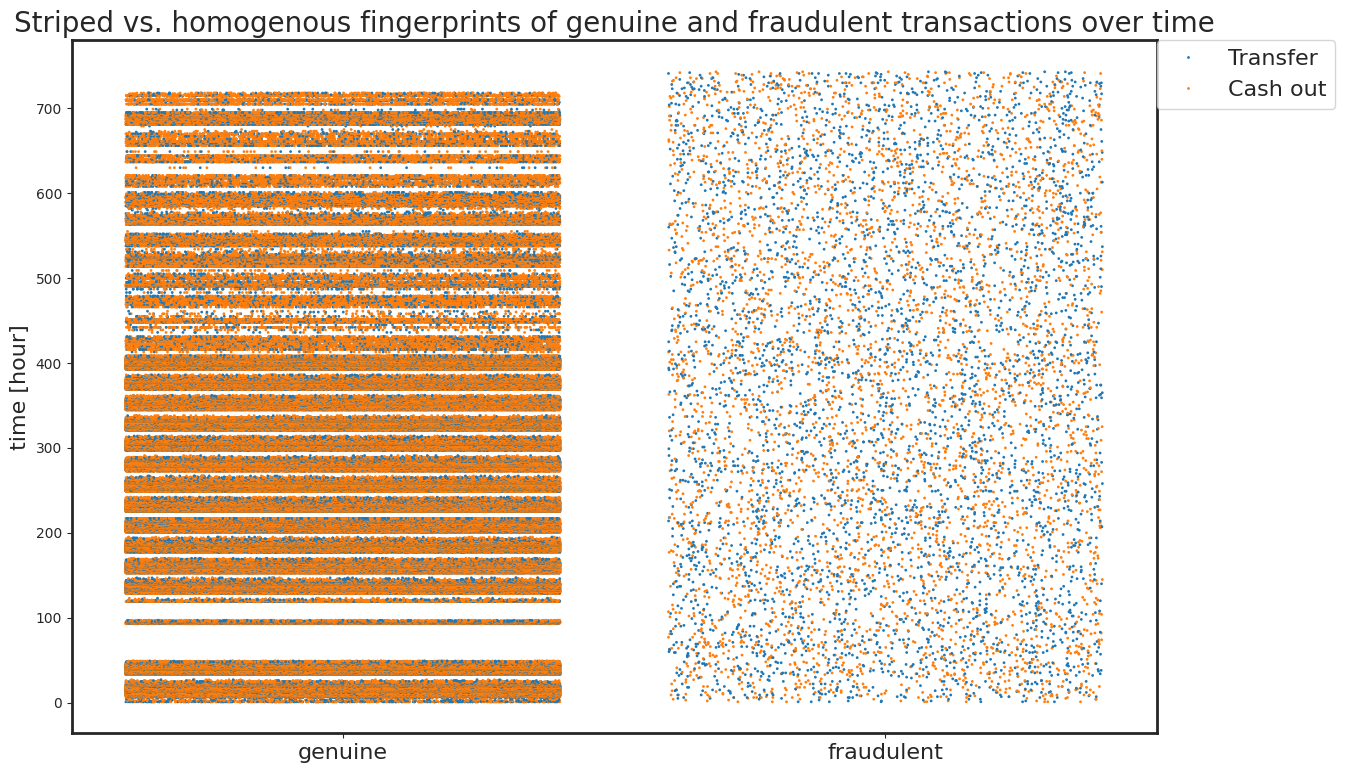

In [46]:
limit = len(X)

# Plot the stripplot using the first 'limit' rows of data
ax = plotStrip(Y[:limit], X.step[:limit], X.type[:limit])

# Set the y-axis label with a larger font size
ax.set_ylabel('time [hour]', size=16)

# Set the plot title with a larger font size
ax.set_title(
    'Striped vs. homogenous fingerprints of genuine and fraudulent transactions over time',
    size=20
)

# Show the plot
plt.show()

<a id='amount'></a>
##### 5. 2. Dispersion over amount

C:\Users\vrajd\AppData\Local\Temp\ipykernel_14196\1347895853.py:24: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  ax = sns.stripplot(
C:\Users\vrajd\AppData\Local\Temp\ipykernel_14196\1347895853.py:24: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  ax = sns.stripplot(
C:\Users\vrajd\AppData\Local\Temp\ipykernel_14196\1347895853.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['genuine', 'fraudulent'], size=16)


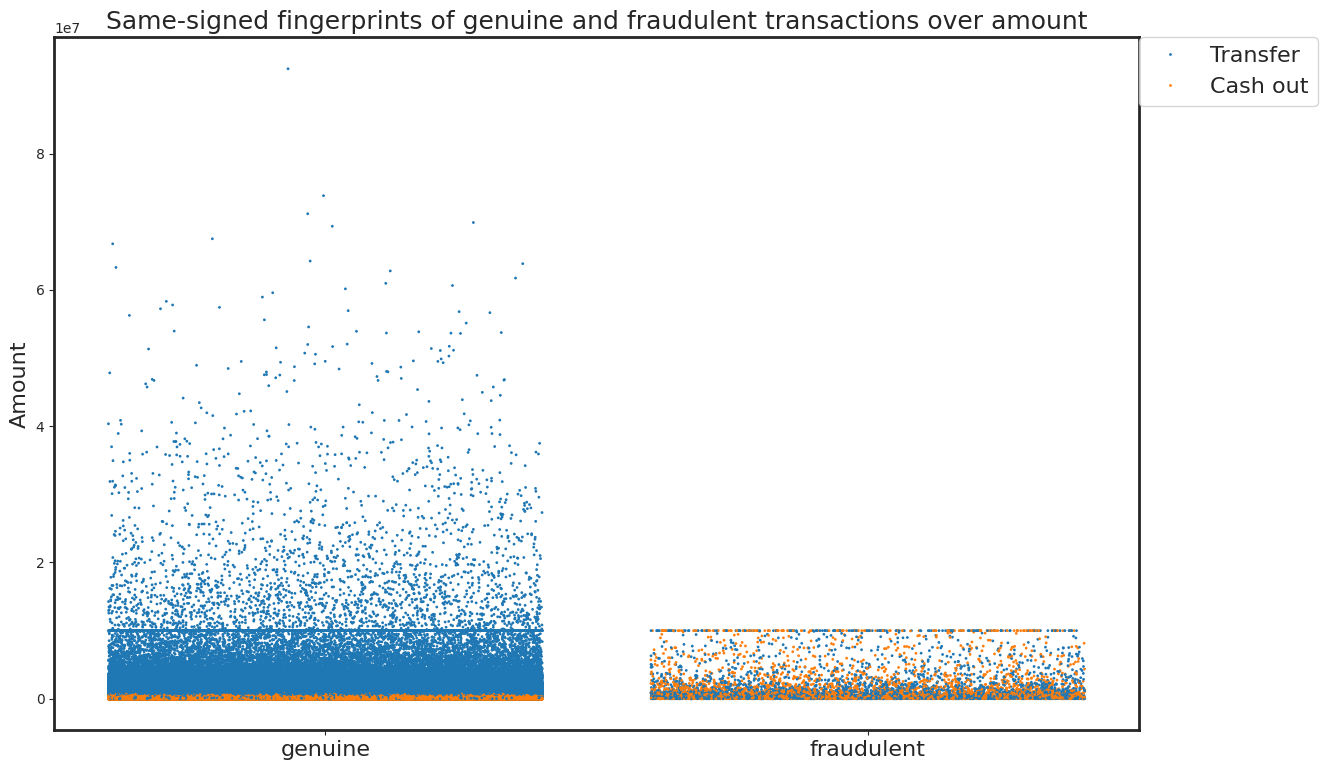

In [47]:

limit = len(X)

# Plot stripplot of genuine vs fraudulent transactions over 'amount'
ax = plotStrip(Y[:limit],          # Fraud label (0 or 1)
               X.amount[:limit],   # Transaction amount
               X.type[:limit],     # Transaction type (encoded)
               figsize=(14, 9))    # Figure size

# Set y-axis label and plot title with readable font sizes
ax.set_ylabel('Amount', size=16)
ax.set_title('Same-signed fingerprints of genuine and fraudulent transactions over amount', size=18)

# Show plot (if not automatically displayed)
plt.show()


<a id='error'></a>
##### 5. 3. Dispersion over error in balance in destination accounts

C:\Users\vrajd\AppData\Local\Temp\ipykernel_14196\1347895853.py:24: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  ax = sns.stripplot(
C:\Users\vrajd\AppData\Local\Temp\ipykernel_14196\1347895853.py:24: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  ax = sns.stripplot(
C:\Users\vrajd\AppData\Local\Temp\ipykernel_14196\1347895853.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['genuine', 'fraudulent'], size=16)


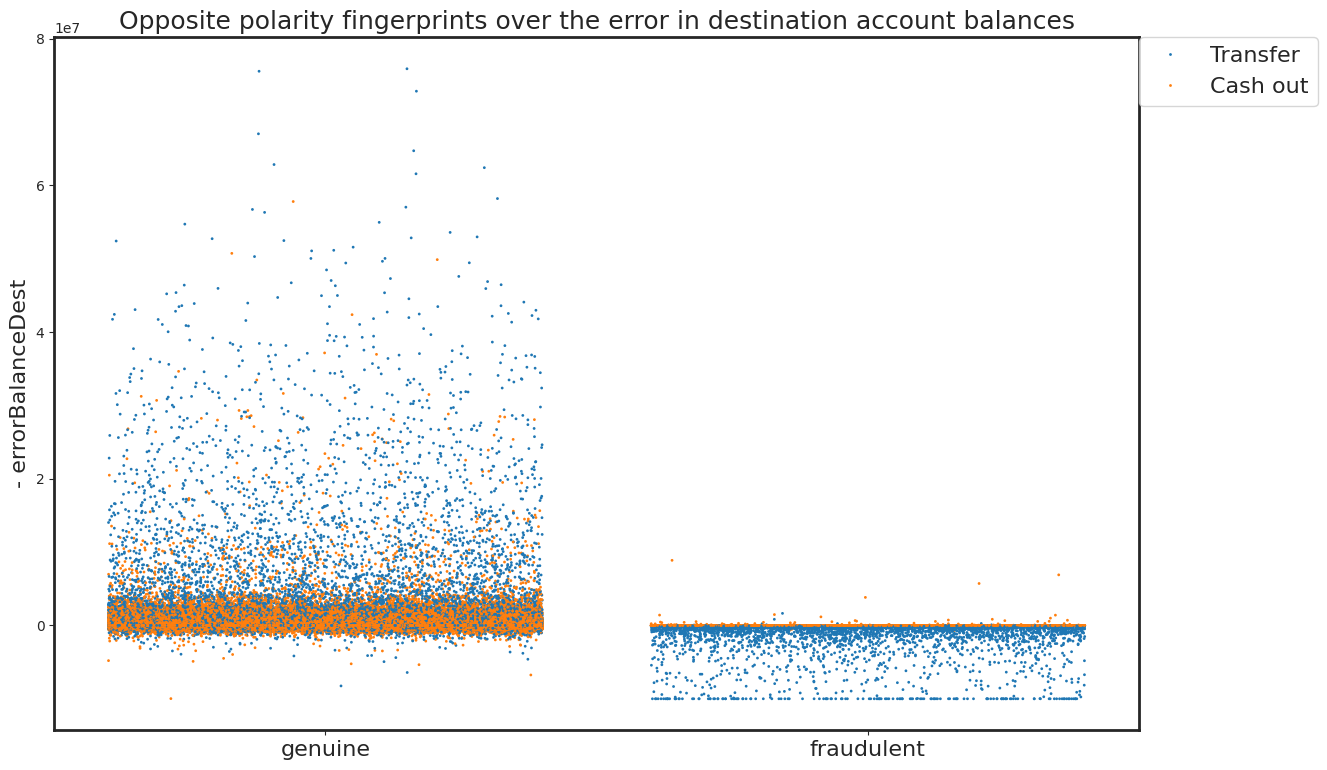

In [48]:

limit = len(X)

# Plot stripplot of genuine vs fraudulent transactions over negative errorBalanceDest
ax = plotStrip(Y[:limit],               # Fraud label (0 or 1)
               -X.errorBalanceDest[:limit],  # Negative error in destination balance
               X.type[:limit],             # Transaction type (encoded)
               figsize=(14, 9))            # Figure size

# Set y-axis label and plot title with readable font sizes
ax.set_ylabel('- errorBalanceDest', size=16)
ax.set_title('Opposite polarity fingerprints over the error in destination account balances', size=18)

# Show plot (if not automatically displayed)
plt.show()


<a id='separation'></a>
##### 5. 4. Separating out genuine from fraudulent transactions

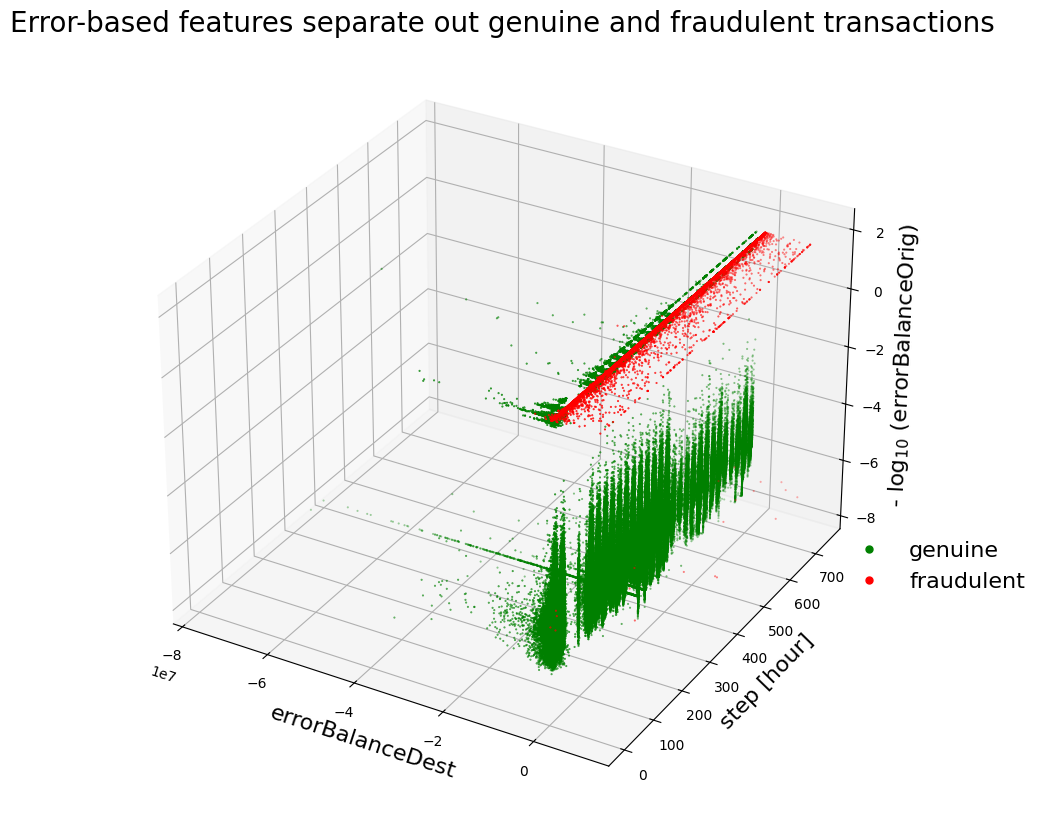

In [49]:
import matplotlib.lines as mlines

# Variables for the axes
x = 'errorBalanceDest'
y = 'step'
z = 'errorBalanceOrig'
zOffset = 0.02  # To avoid log(0)
limit = len(X)  # Number of rows to plot

# Reset seaborn styles to prevent interference with 3D plot defaults
sns.reset_orig()

# Create 3D scatter plot figure and axis
fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot genuine transactions in green
ax.scatter(
    X.loc[Y == 0, x][:limit], 
    X.loc[Y == 0, y][:limit], 
    -np.log10(X.loc[Y == 0, z][:limit] + zOffset), 
    c='g', marker='.', s=1, label='genuine'
)

# Plot fraudulent transactions in red
ax.scatter(
    X.loc[Y == 1, x][:limit], 
    X.loc[Y == 1, y][:limit], 
    -np.log10(X.loc[Y == 1, z][:limit] + zOffset), 
    c='r', marker='.', s=1, label='fraudulent'
)

# Set axis labels and title with readable font size
ax.set_xlabel(x, size=16)
ax.set_ylabel(f'{y} [hour]', size=16)
ax.set_zlabel(f'- log$_{{10}}$ ({z})', size=16)
ax.set_title('Error-based features separate out genuine and fraudulent transactions', size=20)

# Make axis tight and enable grid
plt.axis('tight')
ax.grid(True)

# Create custom legend markers
noFraudMarker = mlines.Line2D([], [], linewidth=0, color='g', marker='.', markersize=10, label='genuine')
fraudMarker = mlines.Line2D([], [], linewidth=0, color='r', marker='.', markersize=10, label='fraudulent')

# Place legend outside plot
plt.legend(handles=[noFraudMarker, fraudMarker], bbox_to_anchor=(1.20, 0.38), frameon=False, prop={'size': 16})

# Show the plot
plt.show()


<a id='correlation'></a>
##### 5. 5. Fingerprints of genuine and fraudulent transactions

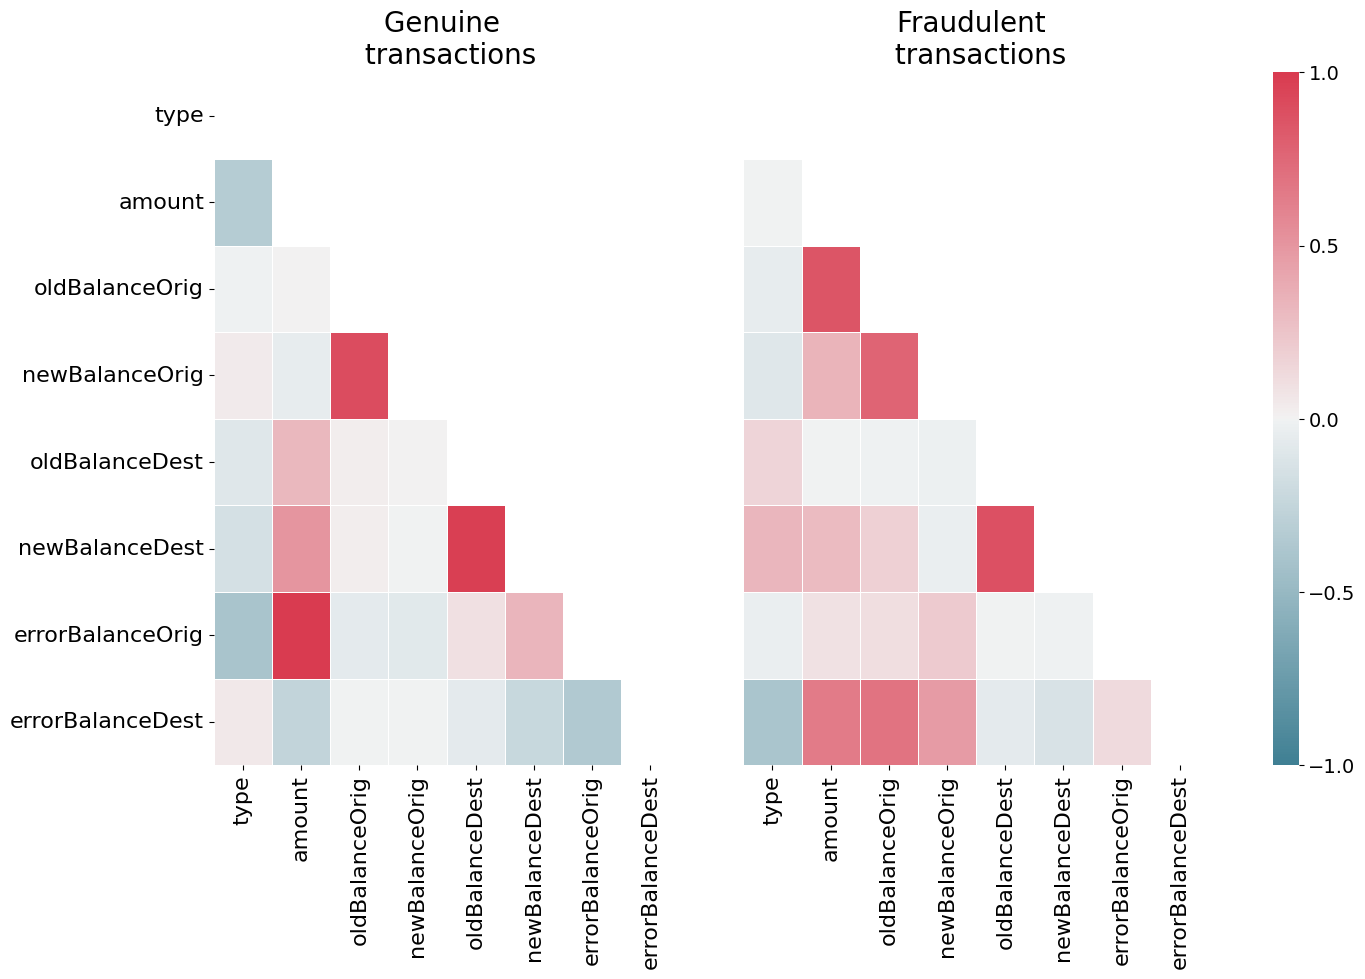

In [50]:
# Separate data into fraudulent and genuine sets based on Y labels
Xfraud = X.loc[Y == 1]
XnonFraud = X.loc[Y == 0]

# Calculate correlation matrices excluding the 'step' column for genuine transactions
correlationNonFraud = XnonFraud.loc[:, X.columns != 'step'].corr()

# Create a mask for the upper triangle of the correlation matrix
mask = np.zeros_like(correlationNonFraud)
indices = np.triu_indices_from(correlationNonFraud)
mask[indices] = True

# Set up the grid layout for side-by-side heatmaps with colorbar
grid_kws = {"width_ratios": (.9, .9, .05), "wspace": 0.2}
f, (ax1, ax2, cbar_ax) = plt.subplots(1, 3, gridspec_kw=grid_kws, figsize=(14, 9))

# Use a diverging colormap for visualizing correlations
cmap = sns.diverging_palette(220, 8, as_cmap=True)

# Heatmap for genuine transactions correlations (masked upper triangle)
sns.heatmap(
    correlationNonFraud,
    ax=ax1,
    vmin=-1,
    vmax=1,
    cmap=cmap,
    square=False,
    linewidths=0.5,
    mask=mask,
    cbar=False
)
ax1.set_xticklabels(ax1.get_xticklabels(), size=16)
ax1.set_yticklabels(ax1.get_yticklabels(), size=16)
ax1.set_title('Genuine \n transactions', size=20)

# Correlation matrix for fraudulent transactions (exclude 'step')
correlationFraud = Xfraud.loc[:, X.columns != 'step'].corr()

# Heatmap for fraudulent transactions correlations with colorbar on right
sns.heatmap(
    correlationFraud,
    ax=ax2,
    vmin=-1,
    vmax=1,
    cmap=cmap,
    square=False,
    linewidths=0.5,
    mask=mask,
    yticklabels=False,
    cbar_ax=cbar_ax,
    cbar_kws={'orientation': 'vertical', 'ticks': [-1, -0.5, 0, 0.5, 1]}
)
ax2.set_xticklabels(ax2.get_xticklabels(), size=16)
ax2.set_title('Fraudulent \n transactions', size=20)

# Format colorbar tick labels size
cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), size=14)

# Display the plot
plt.show()


---

### **Graph 1: Time vs Transaction Type (Genuine vs Fraudulent)**

* Genuine transactions show a striped pattern over time, indicating regular, periodic activity.
* Fraudulent transactions are randomly distributed, showing no temporal regularity.
* This suggests fraudsters act at unpredictable times to avoid detection.

---

### **Graph 2: Amount vs Transaction Type (Genuine vs Fraudulent)**

* Genuine transactions vary widely in amount, especially for Transfers.
* Fraudulent transactions are tightly clustered in a lower range, with similar Transfer and Cash out values.
* This indicates fraudsters often use consistent amounts, potentially to bypass detection thresholds.

---

### **Graph 3: Error-based Features (3D Plot)**

* Genuine transactions (green) have a wide spread in balance errors but cluster around consistent patterns.
* Fraudulent transactions (red) form a distinct, separate cluster with different error profiles.
* Error-based features like `errorBalanceOrig` and `errorBalanceDest` help effectively distinguish fraud.

---


<a id='ML'></a>
#### 6. Machine Learning to Detect Fraud in Skewed Data


* **Metric Selection**: Due to class imbalance, the Area Under the Precision-Recall Curve (AUPRC) is preferred over AUROC, as it better captures performance differences in imbalanced datasets ([Davis & Goadrich, 2006](http://pages.cs.wisc.edu/~jdavis/davisgoadrichcamera2.pdf)).

* **Handling Imbalance**: Rather than discarding majority class data (undersampling), techniques like SMOTE are considered for oversampling; however, the best results came from using tree-based ensemble models that natively handle imbalance.

* **Algorithm Choice**: XGBoost outperformed other methods like Random Forest due to its robustness with missing data, parallelization support, and ability to assign higher weights to the minority (fraudulent) class.


In [53]:
# Compute skew to understand class imbalance
print('skew = {}'.format(len(Xfraud) / float(len(X))))

# Split dataset into training and testing sets
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=randomState)

# Calculate class weights to handle imbalance
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())

# Train XGBoost classifier with class weights and evaluate with AUPRC
clf = XGBClassifier(max_depth=3, scale_pos_weight=weights, n_jobs=4)
probabilities = clf.fit(trainX, trainY).predict_proba(testX)
print('AUPRC = {}'.format(average_precision_score(testY, probabilities[:, 1])))

skew = 0.002964544224336551
AUPRC = 0.9926360768575739


Text(0.5, 1.0, 'Ordering of features by importance to the model learnt')

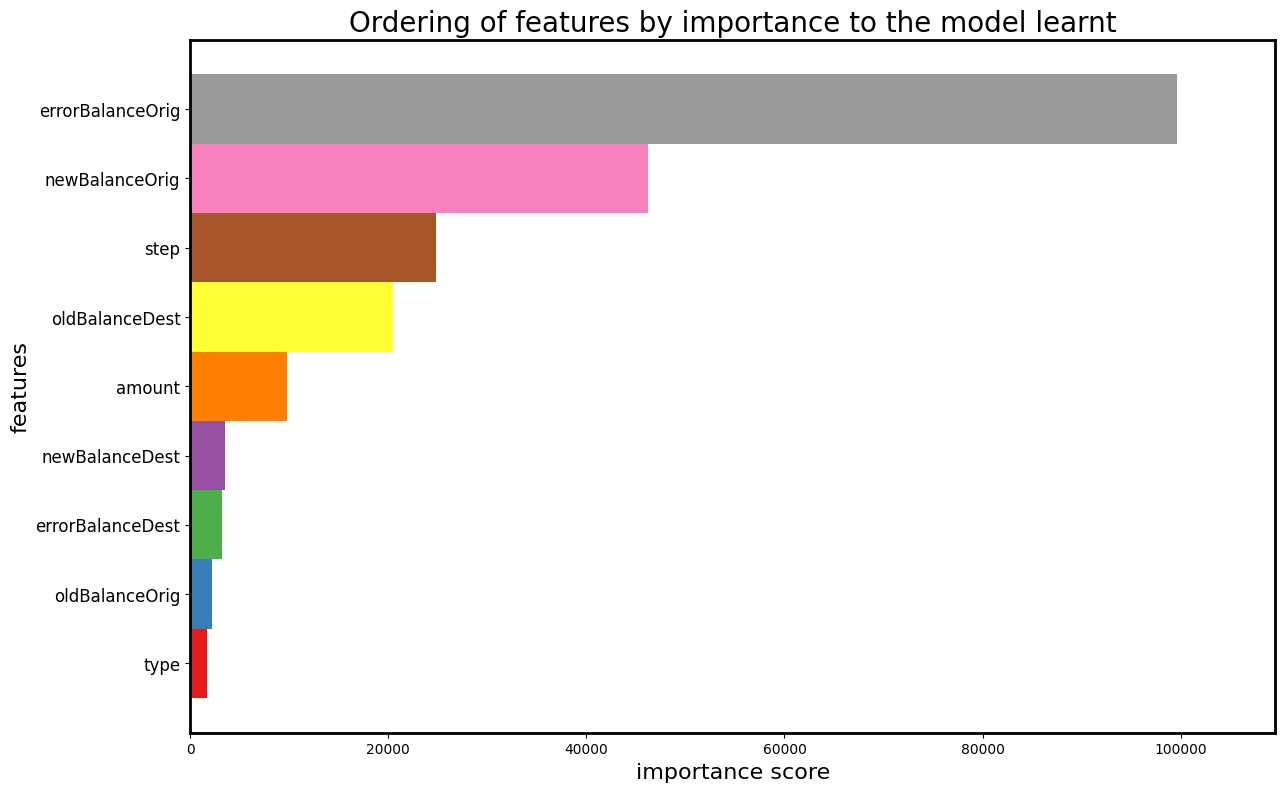

In [57]:
# Plot top features based on importance ('cover')
fig = plt.figure(figsize=(14, 9))
ax = fig.add_subplot(111)
colours = plt.cm.Set1(np.linspace(0, 1, 9))

plot_importance(clf, height=1, color=colours, grid=False,
                show_values=False, importance_type='cover', ax=ax)

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)

ax.set_xlabel('importance score', size=16)
ax.set_ylabel('features', size=16)
ax.set_yticklabels(ax.get_yticklabels(), size=12)
ax.set_title('Ordering of features by importance to the model learnt', size=20)

In [58]:
# Generate learning curve data (can be time-consuming)
trainSizes, trainScores, crossValScores = learning_curve(
    XGBClassifier(max_depth=3, scale_pos_weight=weights, n_jobs=4),
    trainX, trainY, scoring='average_precision'
)

# Compute means and standard deviations
trainScoresMean = np.mean(trainScores, axis=1)
trainScoresStd = np.std(trainScores, axis=1)
crossValScoresMean = np.mean(crossValScores, axis=1)
crossValScoresStd = np.std(crossValScores, axis=1)

Text(0.5, 1.0, 'Learning curves indicate slightly underfit model')

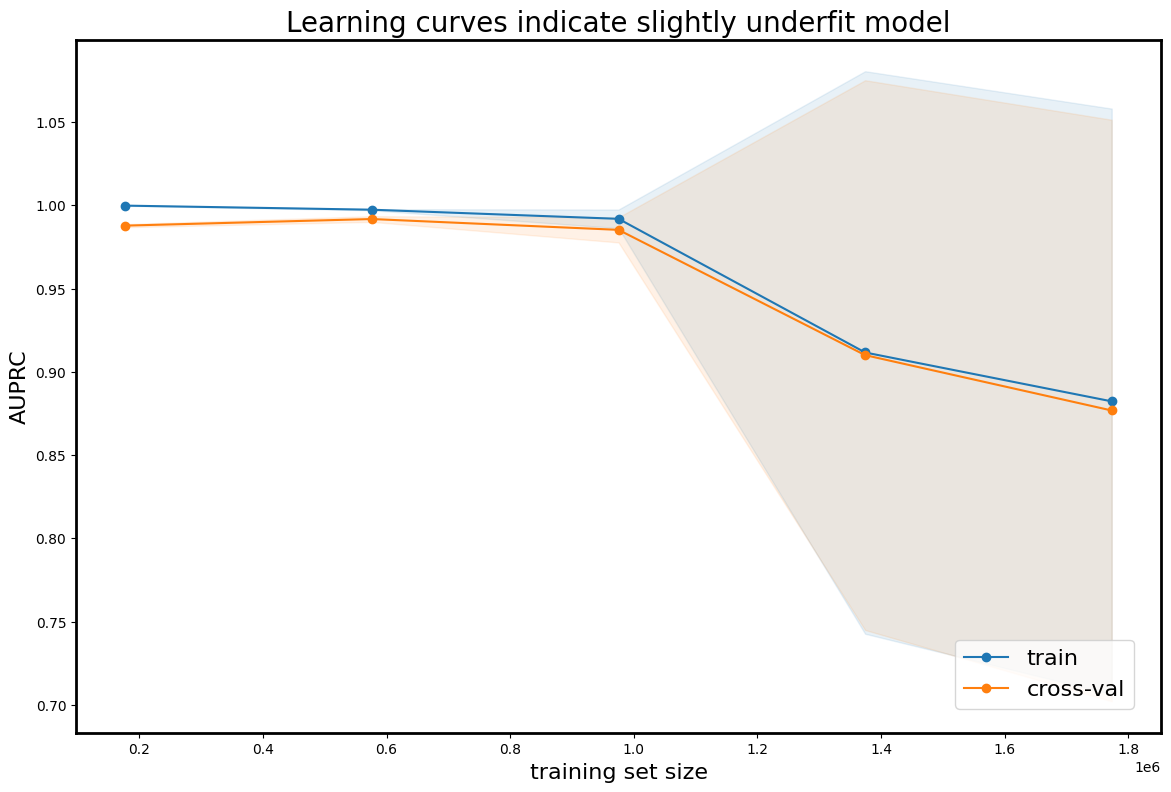

In [59]:
# Visualize model's training and validation performance
colours = plt.cm.tab10(np.linspace(0, 1, 9))
fig = plt.figure(figsize=(14, 9))

plt.fill_between(trainSizes, trainScoresMean - trainScoresStd,
                 trainScoresMean + trainScoresStd, alpha=0.1, color=colours[0])
plt.fill_between(trainSizes, crossValScoresMean - crossValScoresStd,
                 crossValScoresMean + crossValScoresStd, alpha=0.1, color=colours[1])

plt.plot(trainSizes, trainScores.mean(axis=1), 'o-', label='train', color=colours[0])
plt.plot(trainSizes, crossValScores.mean(axis=1), 'o-', label='cross-val', color=colours[1])

ax = plt.gca()
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)

plt.legend(bbox_to_anchor=(0.8, 0.15), loc=2, fontsize=16)
plt.xlabel('training set size', size=16)
plt.ylabel('AUPRC', size=16)
plt.title('Learning curves indicate slightly underfit model', size=20)

In [62]:
# Save the model
import joblib

joblib.dump(clf, 'fraud_model.pkl')
print("Model saved as fraud_model.pkl")

Model saved as fraud_model.pkl


Important Features: errorBalanceDest, errorBalanceOrig, amount, type, oldBalanceDest, newBalanceDest, oldBalanceOrig, newBalanceOrig, and marginally step. These are critical because they capture balance anomalies, transaction type, and amount patterns that distinguish fraud.

Fraud occurs in TRANSFER and CASH_OUT, with zero destination balances as a key indicator. Engineered error features are highly discriminative, and the model effectively handles imbalance, but fraud patterns are subtle and complex.